In [17]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)

<module 'postprocessing_utils' from '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/python/postprocessing_utils.pyc'>

In [18]:
ntuples = 'ntuples_20180524'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s or "node_SM" in s]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s]
diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s]
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]
ggH = [s for s in files if "GluGluHToGG_M-125" in s]
ttH = [s for s in files if "ttHToGG_M125" in s]

utils.IO.add_signal(ntuples,signal,1)
utils.IO.add_background(ntuples,diphotonJets,-1)
utils.IO.add_background(ntuples,gJets_lowPt,-2)
utils.IO.add_background(ntuples,gJets_highPt,-2)
#utils.IO.add_background(ntuples,diphotonJets_1B,-1)
#utils.IO.add_background(ntuples,diphotonJets_2B,-1)
#utils.IO.add_background(ntuples,ggH,-3)
#utils.IO.add_background(ntuples,ttH,-4)


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_20180524
using background file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_20180524/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_20180524/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_20180524/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_20180524/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root


In [19]:
from ROOT import TLorentzVector
###simple stupid test
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",")

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,DiJetDiPho_DR'.split(",")

###### REMOVING DR(hh) since not SAFE
### remove DR if you don't want to use it
### adding minDr(Gamma,Jet)
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:diphotonCandidate.Pt()/(diHiggsCandidate.M()),noexpand:diphotonCandidate.Pt()/dijetCandidate.Pt(),noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:dijetCandidate.Pt()/(diHiggsCandidate.M())'.split(',') # old 2016 variables
#### Trying to add Mjj as variable, removing DR
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,noexpand:dijetCandidate.M()'.split(",")
#### Trying to add Mjj as variable, keeping DR
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,DiJetDiPho_DR,noexpand:dijetCandidate.M()'.split(",")
#### Trying to add Mjj as variable, removing DR, adding minDr(Gamma,Jet)
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidate.M(),noexpand:dijetCandidate.Pt()/diHiggsCandidate.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr,noexpand:dijetCandidate.M()'.split(",")

branch_names = 'leadingJetCorr_bDis,subleadingJetCorr_bDis,noexpand:fabs(CosThetaStar_CS),noexpand:fabs(CosTheta_bb),noexpand:fabs(CosTheta_gg),noexpand:diphotonCandidate.Pt()/diHiggsCandidateCorr.M(),noexpand:dijetCandidateCorr.Pt()/diHiggsCandidateCorr.M(),customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'leadingJet_bRegNNResolution,subleadingJet_bRegNNResolution,dijetSigmaMOverM'.split(",")
branch_names = branch_names+b_reg_branches

branch_names = [c.strip() for c in branch_names]
#branch_names = (b.replace(" ", "_") for b in branch_names)
#branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names

import pandas as pd
import root_pandas as rpd

#utils.IO.get_cross_sections('jsons/datasets80X_Moriond.json')
#utils.IO.w_sig.append(utils.IO.get_weight('signal','nrSM',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','DiPhoJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',0))
#utils.IO.w_bkg(utils.IO.get_weight('background','GJets',1))


preprocessing.set_signals_and_backgrounds("bbggSelectionTree",branch_names)
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.set_variables(branch_names)

#relative weighting between components of one class is kept, all classes normalized to the same
weights_sig=preprocessing.weight_signal_with_resolution(weights_sig,y_sig)
weights_sig=preprocessing.weight_signal_with_resolution_bjet(weights_sig,y_sig)
#reweight also resonant higgs with resolution
#weights_bkg=preprocessing.weight_background_with_resolution(weights_bkg,y_bkg,-3)
#weights_bkg=preprocessing.weight_background_with_resolution(weights_bkg,y_bkg,-4)


weights_bkg,weights_sig=preprocessing.normalize_process_weights(weights_bkg,y_bkg,weights_sig,y_sig)

#######correct weight
#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-3.,0.0049)
#try to increase weight of ggH
#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-3.,0.049)

#weights_bkg=preprocessing.scale_process_weight(weights_bkg,y_bkg,-4.,0.00044)

X_bkg,y_bkg,weights_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg)
#X_sig,y_sig,weights_sig = preprocessing.randomize(X_sig,y_sig,weights_sig)


print X_bkg.shape
print y_bkg.shape
#bbggTrees have by default signal and CR events, let's be sure that we clean it
X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig=preprocessing.clean_signal_events(X_bkg,y_bkg,weights_bkg,X_sig,y_sig,weights_sig)
print X_bkg.shape
print y_bkg.shape

y_total_train = preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample(X_sig,X_bkg)

y_total_test = preprocessing.get_total_test_sample(y_sig,y_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample(X_sig,X_bkg)

w_total_train = preprocessing.get_total_training_sample(weights_sig,weights_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample(weights_sig,weights_bkg).ravel()


['leadingJetCorr_bDis', 'subleadingJetCorr_bDis', 'noexpand:fabs(CosThetaStar_CS)', 'noexpand:fabs(CosTheta_bb)', 'noexpand:fabs(CosTheta_gg)', 'noexpand:diphotonCandidate.Pt()/diHiggsCandidateCorr.M()', 'noexpand:dijetCandidateCorr.Pt()/diHiggsCandidateCorr.M()', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverMDecorr', 'PhoJetMinDr', 'leadingJet_bRegNNResolution', 'subleadingJet_bRegNNResolution', 'dijetSigmaMOverM']
using tree:bbggSelectionTree
using tree:bbggSelectionTree
(331870, 16)
(331870, 1)
(273386, 16)
(273386, 1)


In [ ]:
#X_sig = X_total_train[np.where(y_total_train==1),:][0]
#X_bkg = X_total_train[np.where(y_total_train==-1),:][0]
#plotting.plot_input_variables(X_sig,X_bkg,branch_names,None,30,'withBREG')

In [20]:
########final optimization with all fixed#######

from sklearn.externals import joblib
import xgboost as xgb

#optimized parameters
clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1e-05, missing=None, n_estimators=1500, nthread=20,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('~/HHbbgg_ETH_devel/Training/output_files/training_with_2017variablesREG.pkl'), compress=9)

['/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_2017variablesREG.pkl']

In [21]:
import matplotlib.pyplot as plt
outstr = "2017variablesREG"
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr

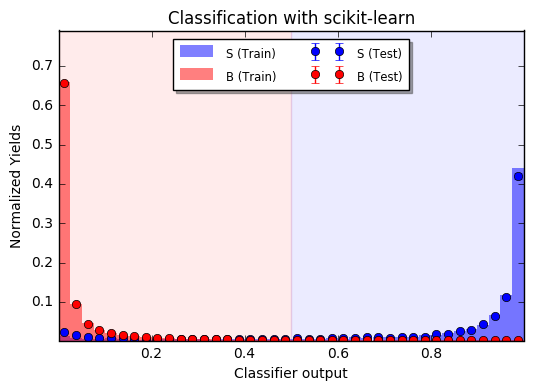

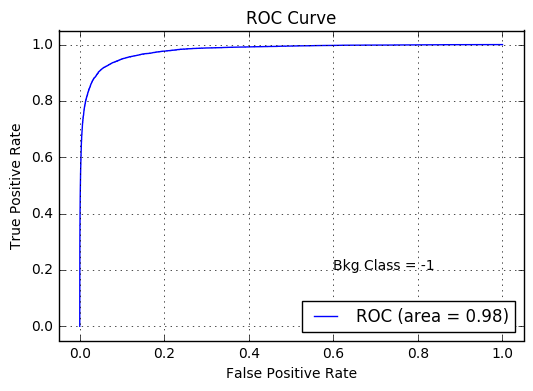

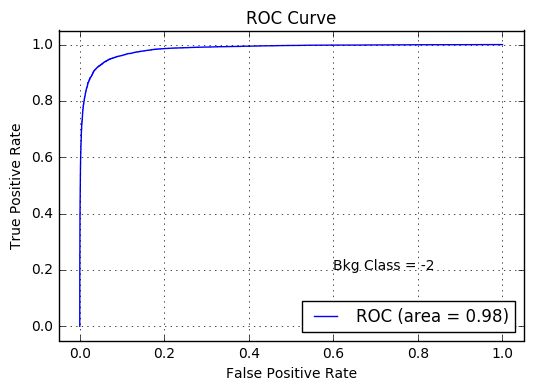

In [22]:
plt.clf()
plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()
fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()
fpr_gJets_2ndtest_2,tpr_gJets_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
plt.show()
#fpr_dipho_2ndtest_2,tpr_dipho_2ndtest_2 = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-3,outString="xgbr_diphotonsBJets_resWeighting_optimized_ggH_reweight_smalltest",weights=w_total_test)
#plt.show()
